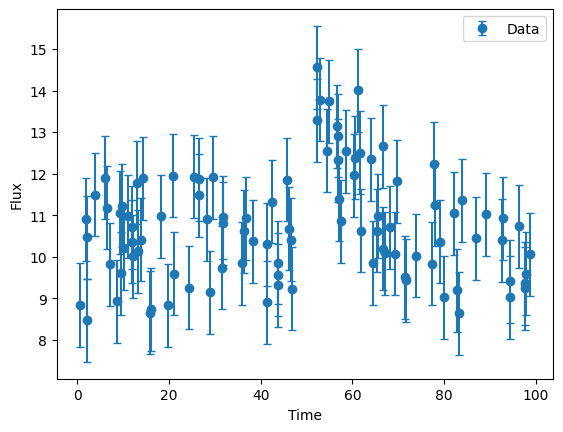

In [3]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")

time_data, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time_data, flux, yerr=err, fmt='o', label='Data', capsize=3)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()


/tmp/ipykernel_41297/1271079644.py:8: RuntimeWarning: overflow encountered in exp
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
/tmp/ipykernel_41297/1271079644.py:8: RuntimeWarning: overflow encountered in multiply
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
1746it [00:02, 437.83it/s, bound: 0 | nc: 114 | ncall: 17229 | eff(%): 10.134 | loglstar:   -inf < -271.114 <    inf | logz: -279.352 +/-  0.122 | dlogz: 114.168 >  0.509]  /tmp/ipykernel_41297/1271079644.py:8: RuntimeWarning: overflow encountered in exp
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
/tmp/ipykernel_41297/1271079644.py:8: RuntimeWarning: overflow encountered in multiply
  C + A * np.exp(- alpha *(t - t0)))          # else , hp function
1832it [00:02, 274.90it/s, bound: 1 | nc: 11 | ncall: 18332 | eff(%):  9.993 | loglstar:   -inf < -248.930 <    inf | logz: -257.283 +/-  0.122 | dlogz: 91.918 >  0.509]  /tmp/ipykernel_41297/1271079644.py:8: RuntimeWarni

(<Figure size 970x970 with 16 Axes>,
 array([[<Axes: title={'center': '$C$ = ${10.293}_{-0.227}^{+0.242}$'}>,
         <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$A$'>,
         <Axes: title={'center': '$A$ = ${5.368}_{-2.022}^{+3.984}$'}>,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\alpha$'>, <Axes: >,
         <Axes: title={'center': '$\\alpha$ = ${0.122}_{-0.043}^{+0.066}$'}>,
         <Axes: >],
        [<Axes: xlabel='$C$', ylabel='$t_0$'>, <Axes: xlabel='$A$'>,
         <Axes: xlabel='$\\alpha$'>,
         <Axes: title={'center': '$t_0$ = ${49.122}_{-2.152}^{+2.887}$'}, xlabel='$t_0$'>]],
       dtype=object))

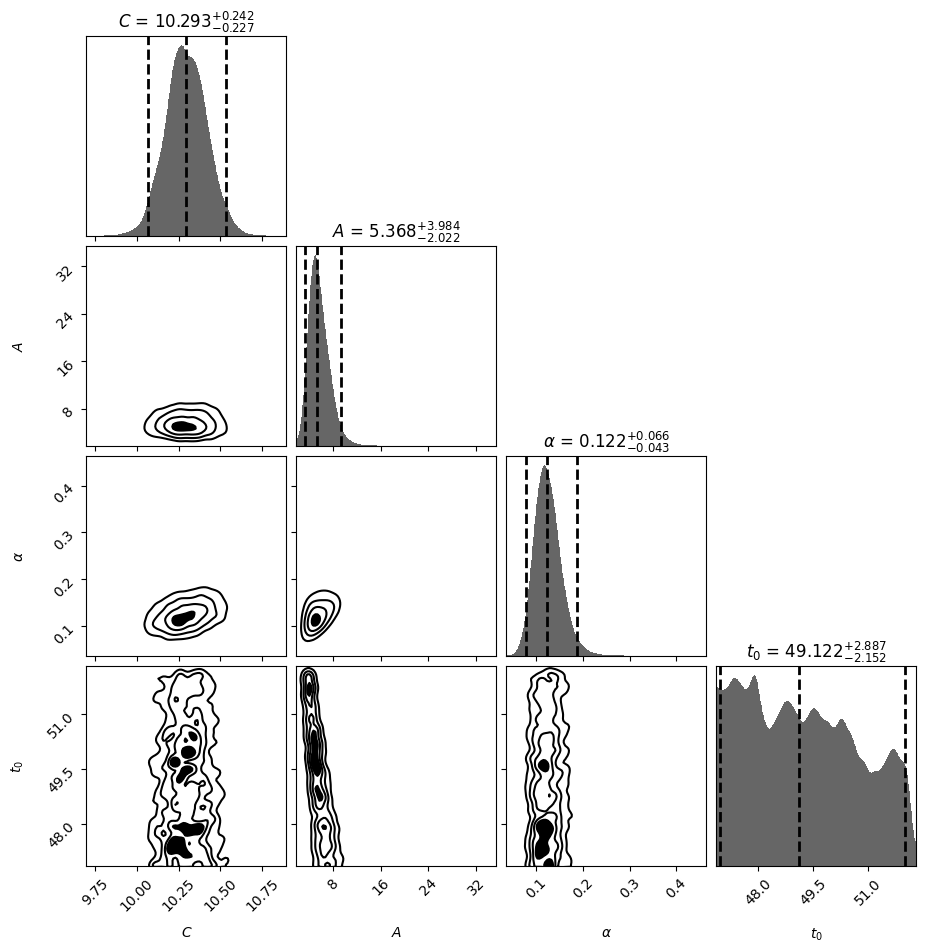

In [4]:
import dynesty
from dynesty import plotting as dyplot

def model (t, theta):
    C, A, alpha, t0 = theta
    return np.where(t < t0,                                     # for t < t0
                    C,                                          #costant
                    C + A * np.exp(- alpha *(t - t0)))          # else , hp function

def loglikelihood(theta):
    model_flux = model(time_data, theta)
    chi2 = np.sum(((flux - model_flux) / err) ** 2)
    logL = -0.5 * chi2 - np.sum(np.log(np.sqrt(2 * np.pi) * err))
    return logL

def prior_transform(u):
    C = 0 + 50 * u[0]                          # Uniform(0, 50)
    A = 0 + 50 * u[1]                          # Uniform(0, 50)
    alpha = np.exp(-5 + 10 * u[2])             # Log-uniform in [e^-5, e^5]
    t0 = 0 + 100 * u[3]                        # Uniform(0, 100)
    return [C, A, alpha, t0]


ndim = 4

sampler = dynesty.NestedSampler(loglikelihood, prior_transform , ndim)
sampler.run_nested()    
sresult = sampler.results
labels = [r"$C$", r"$A$", r"$\alpha$", r"$t_0$"]
dyplot.cornerplot(sresult, show_titles=True, labels=labels, title_fmt=".3f")

=== Parameters compare ===
Dynesty (MAP):       C=10.276, A=5.326, alpha=0.119, t0=49.278
curve_fit:           C=10.298, A=3.707, alpha=0.117, t0=52.185


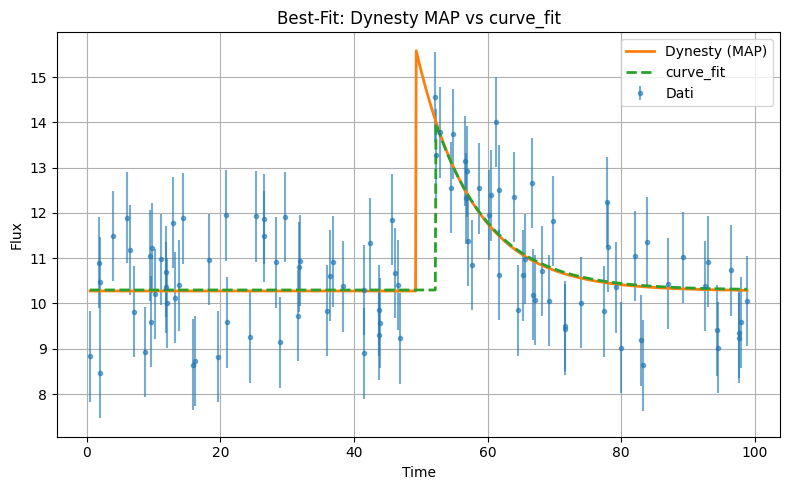

In [5]:
from scipy.optimize import curve_fit

def model_curve_fit(t, C, A, alpha, t0):
    return np.where(t < t0,
                    C,
                    C + A * np.exp(-alpha * (t - t0)))

# initial values for fitting
C0 = np.median(flux)
A0 = np.max(flux) - C0
alpha0 = 0.1
t0_init = time_data[np.argmax(flux)]


# === Dynesty:  MAP Max At Posteriori ===
best_idx = np.argmax(sresult.logl)
pars_map = sresult.samples[best_idx]
C_map, A_map, alpha_map, t0_map = pars_map

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit, time_data, flux, sigma=err, p0=[C0, A0, alpha0, t0_init])
C_cf, A_cf, alpha_cf, t0_cf = popt

# === Comparison ===
print("=== Parameters compare ===")
print(f"Dynesty (MAP):       C={C_map:.3f}, A={A_map:.3f}, alpha={alpha_map:.3f}, t0={t0_map:.3f}")
print(f"curve_fit:           C={C_cf:.3f}, A={A_cf:.3f}, alpha={alpha_cf:.3f}, t0={t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_map = model(t_fit, pars_map)
flux_cf  = model(t_fit, popt)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_map, '-', lw=2, label='Dynesty (MAP)', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Best-Fit: Dynesty MAP vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


6482it [00:11, 575.23it/s, +500 | bound: 26 | nc: 1 | ncall: 37499 | eff(%): 18.871 | loglstar:   -inf < -144.329 <    inf | logz: -156.564 +/-  0.156 | dlogz:  0.001 >  0.509]


(<Figure size 970x970 with 16 Axes>,
 array([[<Axes: title={'center': '$C$ = ${10.311}_{-0.231}^{+0.239}$'}>,
         <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='$A$'>,
         <Axes: title={'center': '$A$ = ${2.733}_{-0.712}^{+0.766}$'}>,
         <Axes: >, <Axes: >],
        [<Axes: ylabel='$\\sigma$'>, <Axes: >,
         <Axes: title={'center': '$\\sigma$ = ${5.383}_{-1.550}^{+1.984}$'}>,
         <Axes: >],
        [<Axes: xlabel='$C$', ylabel='$t_0$'>, <Axes: xlabel='$A$'>,
         <Axes: xlabel='$\\sigma$'>,
         <Axes: title={'center': '$t_0$ = ${55.392}_{-1.874}^{+2.061}$'}, xlabel='$t_0$'>]],
       dtype=object))

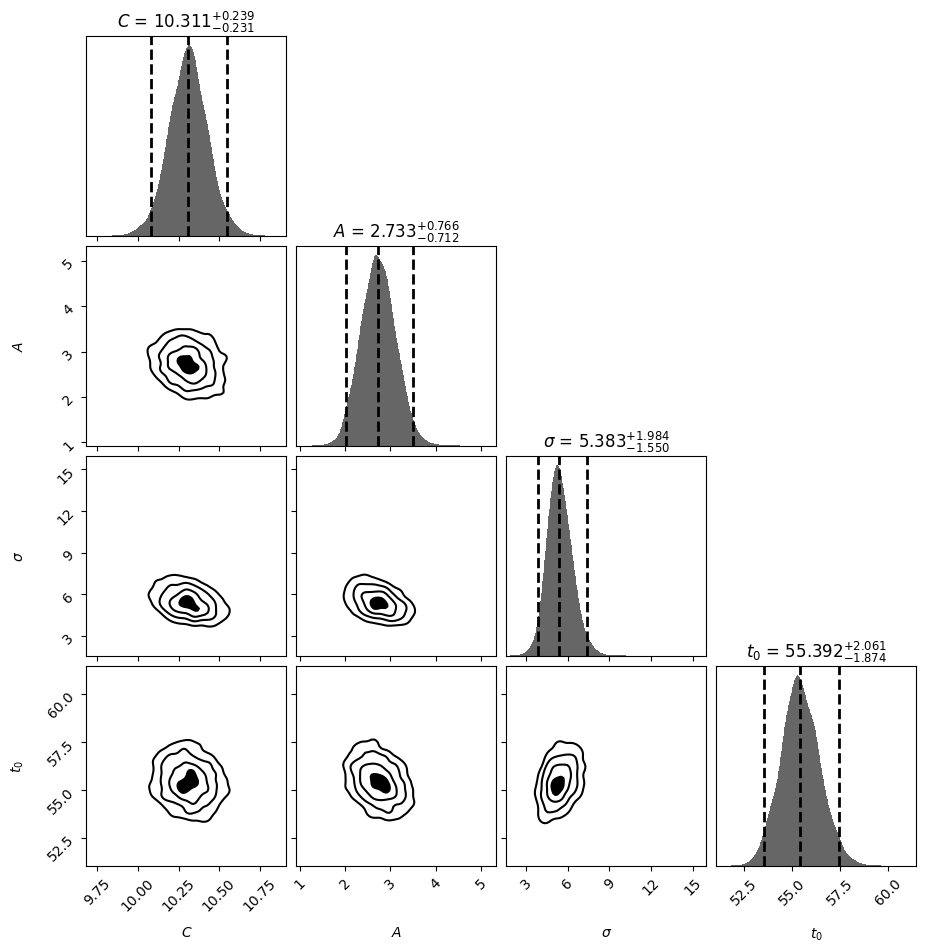

In [6]:
def model2(t, theta):
    C, A, sigma, t0 = theta
    return C + A * np.exp(-(t - t0)**2 / (2 * sigma**2))

def prior_transform2(u):

    ymin = np.min(flux)
    ymax = np.max(flux)
    C = ymin + (ymax - ymin) * u[0]            # Uniform between min and max of the flux
    
    A = 0 + (ymax-ymin) * u[1]                 # Uniform between the "base" and the peak
    
    sigma = 0 + 100*u[2]                        # uniform in 0 - 100

    T = time_data[np.argmax(flux)]
    ymin = T - 30
    ymax = T + 30
    t0 = ymin + (ymax - ymin) * u[3]                # Uniform between T-30 and T + 30

    return [C, A, sigma, t0]

def loglikelihood2(theta):
    C, A, sigma, t0 = theta
    model_flux = model2(time_data, theta)
    chi2 = np.sum(((flux - model_flux) / err) ** 2)
    logL = -0.5 * chi2 - np.sum(np.log(np.sqrt(2 * np.pi) * err))
    return logL

ndim = 4

sampler = dynesty.NestedSampler(loglikelihood2, prior_transform2 , ndim)
sampler.run_nested()
sresult = sampler.results
labels = [r"$C$", r"$A$", r"$\sigma$", r"$t_0$"]
dyplot.cornerplot(sresult, show_titles=True, labels=labels, title_fmt=".3f")


=== Parameters compare ===
Dynesty (MAP):       C=10.331, A=2.762, alpha=5.186, t0=55.403
curve_fit:           C=10.307, A=2.751, alpha=5.370, t0=55.473


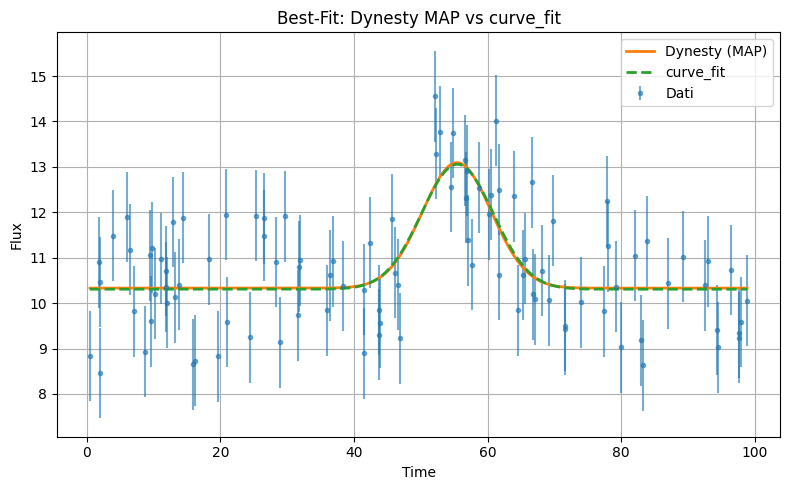

In [7]:
from scipy.optimize import curve_fit

def model_curve_fit2(t, C, A, sigma ,t0):
        return C + A * np.exp(-(t - t0)**2 / (2 * sigma**2))

# initial values for fitting
C0 = np.median(flux)
A0 = np.max(flux) - C0
sigma0 = 3
t0_init = time_data[np.argmax(flux)]


# === Dynesty: MAP : Max At Posteriori ===
best_idx = np.argmax(sresult.logl)
pars_map = sresult.samples[best_idx]
C_map, A_map, alpha_map, t0_map = pars_map

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit2, time_data, flux, sigma=err, p0=[C0, A0, sigma0, t0_init])
C_cf, A_cf, alpha_cf, t0_cf = popt

# === comparison ===
print("=== Parameters compare ===")
print(f"Dynesty (MAP):       C={C_map:.3f}, A={A_map:.3f}, alpha={alpha_map:.3f}, t0={t0_map:.3f}")
print(f"curve_fit:           C={C_cf:.3f}, A={A_cf:.3f}, alpha={alpha_cf:.3f}, t0={t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_map = model2(t_fit, pars_map)
flux_cf  = model2(t_fit, popt)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_map, '-', lw=2, label='Dynesty (MAP)', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Best-Fit: Dynesty MAP vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()